<a href="https://colab.research.google.com/github/TioHalu/Forest_Fire_Prediction_Colab/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.4 MB/s eta 0:00:00


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from itertools import product
import itertools
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

data=pd.read_csv('/content/drive/MyDrive/tugas/dataset/Kab. Muaro Jambi.csv',parse_dates=True)
data  = data.rename(columns={'Tanggal':'Date','Tavg':'Temperature','RH_avg':'Humidity','ff_avg':'Wind','RR':'Rainfall'})
data = data[1:100]
data = data['Humidity']
data = data.replace('',math.nan)
data = data.replace(8888.0,math.nan)
data = data.replace(0.0,math.nan)
data = data.fillna(data.mean())
warnings.filterwarnings('ignore')

# split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# fit ARIMA model to training data
model = auto_arima(train_data, seasonal=False, error_action='ignore', suppress_warnings=True)
model.fit(train_data)

# define function for rolling forecasting
def rolling_forecast(data, model, window_size):
    forecasts = []
    actuals = []
    for i in range(window_size, len(data)):
        # get train data and test data for this iteration
        train_data = data[i-window_size:i]
        test_data = data[i]
        
        # fit ARIMA model to train data and make prediction
        model = ARIMA(train_data, order=model.order)
        model_fit = model.fit()
        forecast = model_fit.forecast()[0]
        
        # append forecast and actual values
        forecasts.append(forecast)
        actuals.append(test_data)
    
    # calculate r square
    r2 = r2_score(actuals, forecasts)
    
    return r2

# define window size for rolling forecasting
window_size = 12

# perform rolling forecasting with different models and select the one with the highest r square
best_model = None
best_r2 = -np.inf
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()
                r2 = rolling_forecast(test_data, model_fit, window_size)
                if r2 > best_r2:
                    best_r2 = r2
                    best_model = model_fit
            except:
                continue

# make predictions with the best model
predictions = []
for i in range(len(test_data)):
    model = ARIMA(data[:train_size+i], order=(1,2,2))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predictions.append(forecast)

# calculate r square
r2 = r2_score(test_data, predictions)
r2

-0.8880592473025191

Best ARIMA configuration: p=0, d=1, q=2
Best ARIMA R-squared score: -0.33
Best SARIMA configuration: P=2, D=1, Q=2, m=12
Best SARIMA R-squared score: 0.51


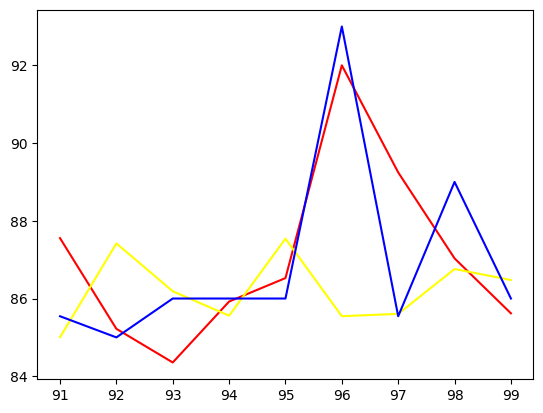

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/tugas/dataset/Kab. Muaro Jambi.csv',parse_dates=True)
data  = data.rename(columns={'Tanggal':'Date','Tavg':'Temperature','RH_avg':'Humidity','ff_avg':'Wind','RR':'Rainfall'})
data = data[1:100]
data = data['Humidity']
data = data.replace('',math.nan)
data = data.replace(8888.0,math.nan)
data = data.replace(0.0,math.nan)
data = data.fillna(data.mean())
warnings.filterwarnings('ignore')
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:90], data[90:]
# Define parameter grid for ARIMA
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Define parameter grid for SARIMA
P_values = range(0, 4)
D_values = range(0, 2)
Q_values = range(0, 4)
m_values = range(12, 13)

# Initialize variables
best_score, best_cfg = float('-inf'), None
best_sarima_score, best_sarima_cfg = float('-inf'), None

# Iterate over all possible combinations of p, d, and q for ARIMA
for p in p_values:
    for d in d_values:
        for q in q_values:
            # Skip if p, d, and q are all 0
            if p==0 and d==0 and q==0:
                continue
            
            # Define and fit the ARIMA model
            model = ARIMA(train, order=(20,d,q))
            model_fit = model.fit()
            
            # Make predictions and calculate R-squared
            predictions = model_fit.predict(start=len(train), end = len(train)+len(test)-1)

            r2 = r2_score(test, predictions)
            # Update best score and configuration if R-squared is higher
            if r2 > best_score:
                best_score, best_cfg, arima = r2, (p,d,q), predictions

# Iterate over all possible combinations of p, d, q, and m for SARIMA
for P in P_values:
    for D in D_values:
        for Q in Q_values:
            for m in m_values:
                # Skip if p, d, and q are all 0
                if P==0 and D==0 and Q==0:
                    continue
                
                # Define and fit the SARIMA model
                model = SARIMAX(data, order=(P,D,Q), seasonal_order=(P,D,Q,m))
                model_fit = model.fit()
                
                # Make predictions and calculate R-squared
                predictions = model_fit.predict(start=len(train), end = len(train)+len(test)-1)
                r2 = r2_score(test, predictions)
                
                # Update best score and configuration if R-squared is higher
                if r2 > best_sarima_score:
                    best_sarima_score, best_sarima_cfg, sarima = r2, (P,D,Q,m), predictions

# Print the best configuration and score for ARIMA and SARIMA
print('Best ARIMA configuration: p={}, d={}, q={}'.format(best_cfg[0], best_cfg[1], best_cfg[2]))
print('Best ARIMA R-squared score: {:.2f}'.format(best_score))
print('Best SARIMA configuration: P={}, D={}, Q={}, m={}'.format(best_sarima_cfg[0], best_sarima_cfg[1], best_sarima_cfg[2], best_sarima_cfg[3]))
print('Best SARIMA R-squared score: {:.2f}'.format(best_sarima_score))

plt.plot(sarima, color="red")
plt.plot(arima, color="yellow")
plt.plot(test, color="blue")

1/1 [==============================] - 0s 19ms/step
Best LSTM configuration: units=50, dropout=0.1
Best R-squared score: 0.03


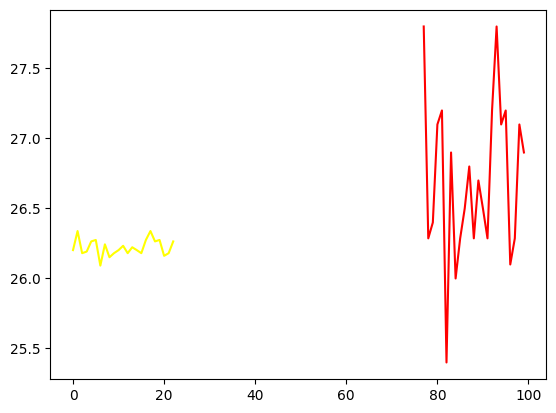

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

data=pd.read_csv('/content/drive/MyDrive/tugas/dataset/Kab. Muaro Jambi.csv',parse_dates=True)
data  = data.rename(columns={'Tanggal':'Date','Tavg':'Temperature','RH_avg':'Humidity','ff_avg':'Wind','RR':'Rainfall'})
data = data[1:100]
data = data['Temperature']
data = data.replace('',math.nan)
data = data.replace(8888.0,math.nan)
data = data.replace(0.0,math.nan)
data = data.fillna(data.mean())
data = pd.DataFrame(data)

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define the function to create LSTM model
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(1,1), dropout=dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Define parameter grid
unit_values = [10, 50, 100]
dropout_values = [0.1, 0.2, 0.3]

# Initialize variables
best_score, best_cfg = float('-inf'), None

# Perform time series cross validation
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, test_idx in tscv.split(data_scaled):
    train_data_scaled = data_scaled[train_idx]
    test_data_scaled = data_scaled[test_idx]
    
    # Iterate over all possible combinations of units and dropout
    for units in unit_values:
        for dropout_rate in dropout_values:
            # Define and fit the LSTM model
            model = create_lstm_model(units=units, dropout_rate=dropout_rate)
            model.fit(train_data_scaled[:-1].reshape(-1,1,1), train_data_scaled[1:], epochs=100, verbose=0)
            
            # Make predictions and calculate R-squared
            train_predictions_scaled = model.predict(train_data_scaled[:-1].reshape(-1,1,1))
            test_predictions_scaled = model.predict(test_data_scaled[:-1].reshape(-1,1,1))
            train_predictions = scaler.inverse_transform(train_predictions_scaled).flatten()
            test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()
            train_r2 = r2_score(data.iloc[train_idx][1:], train_predictions)
            test_r2 = r2_score(data.iloc[test_idx][1:], test_predictions)
            
            # Update best score and configuration if R-squared is higher
            if test_r2 > best_score:
                best_score, best_cfg = test_r2, (units, dropout_rate)
                
# Print the best configuration and score
print('Best LSTM configuration: units={}, dropout={}'.format(best_cfg[0], best_cfg[1]))
print('Best R-squared score: {:.2f}'.format(best_score))
plt.plot(data.iloc[test_idx][1:],color="red")
plt.plot(test_predictions, color="yellow")

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import r2_score, mean_squared_error

data=pd.read_csv('/content/drive/MyDrive/tugas/dataset/Copy of Kab. Badung.csv',parse_dates=True)
data  = data.rename(columns={'Tanggal':'Date','Tavg':'Temperature','RH_avg':'Humidity','ff_avg':'Wind','RR':'Rainfall'})
data = data[1:100]
data = data['Temperature']
data = data.replace('',math.nan)
data = data.replace(8888.0,math.nan)
data = data.replace(0.0,math.nan)
data = data.fillna(data.mean())
warnings.filterwarnings('ignore')
data = pd.DataFrame(data)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:90], data[90:]

# Set parameter untuk Grid Search
param_grid = {'seasonal': ['additive', 'multiplicative'],
              'trend': ['additive', 'multiplicative'],
              'seasonal_periods': [4, 12],
              'smoothing_level': np.linspace(0.1, 0.9, 9),
              'smoothing_slope': np.linspace(0.1, 0.9, 9),
              'smoothing_seasonal': np.linspace(0.1, 0.9, 9)}

# Lakukan Grid Search dengan menggunakan training set
results = []
for seasonal in param_grid['seasonal']:
    for trend in param_grid['trend']:
        for seasonal_period in param_grid['seasonal_periods']:
            for smoothing_level in param_grid['smoothing_level']:
                for smoothing_slope in param_grid['smoothing_slope']:
                    for smoothing_seasonal in param_grid['smoothing_seasonal']:
                        try:
                            model = ExponentialSmoothing(train, 
                                                         seasonal=seasonal, 
                                                         trend=trend, 
                                                         seasonal_periods=seasonal_period)
                            model_fit = model.fit(smoothing_level=smoothing_level, 
                                                  smoothing_slope=smoothing_slope, 
                                                  smoothing_seasonal=smoothing_seasonal)
                             # Make predictions and calculate R-squared
                            predictions = model_fit.predict(start=len(train), end = len(train)+len(test)-1)

                            r2 = r2_score(test, predictions)
                            results.append((seasonal, trend, seasonal_period, smoothing_level, smoothing_slope, smoothing_seasonal, r2))
                        except:
                            print("fs")

# Cari parameter yang menghasilkan r-square terbaik
best_params = max(results, key=lambda x: x[-1])
model = ExponentialSmoothing(train,
                             seasonal=best_params[0],
                             trend=best_params[1],
                             seasonal_periods=best_params[2])
model_fit = model.fit(smoothing_level=best_params[3], 
                      smoothing_slope=best_params[4], 
                      smoothing_seasonal=best_params[5])
predictions = model_fit.forecast(len(test))
r2 = r2_score(test, predictions)
print(r2)
plt.plot(predictions, color="red")
plt.plot(test, color="yellow")

fs
fs
fs
